In [2]:
import numpy as np
import matplotlib.pyplot as plt

import loadutil
data = loadutil.read_complex_byte('dab_plane30s.bin')

print("Data Type:", type(data))
print("Shape of Data:", data.shape[0])
print("First few samples:", data[:10])

Data Type: <class 'numpy.ndarray'>
Shape of Data: 61440000
First few samples: [ 0.125    +1.j         1.       +0.0234375j  0.734375 -0.8671875j
  0.6484375-0.328125j   1.       +0.65625j    1.       -0.1015625j
  0.7734375-0.953125j  -0.5078125-0.8359375j -0.9921875-0.2421875j
 -0.59375  -0.3046875j]


In [4]:
# List to hold each window of data
windows = []
window_size = 500000
num_windows = len(data) // window_size  # calculate the number of complete windows

# Loop through the data to create windows
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    window = data[start_index:end_index]
    windows.append(window)

# To handle any remaining data that doesn't fit a full window
if len(data) % window_size != 0:
    last_window = data[num_windows * window_size:]
    windows.append(last_window)

print(f"Total windows created: {len(windows)}")

if len(windows) >= 100:
    # Cross-correlate the first and second window
    nn = windows[20]
    nn2 = windows[21]
    

N = window_size
fs = 2048000000
bs = 512  # batch size
overlap = 256  # corresponds to maximum timeshift?

t = np.arange(N)/fs
nbatches = int(np.floor((len(nn)-overlap)/bs))

Total windows created: 123


In [5]:
import scipy.signal as signal
def xcorr(x, y):
    rxy = signal.correlate(x, y, mode='full')
    lags = np.arange(-len(x)+1, len(x))
    return lags, rxy

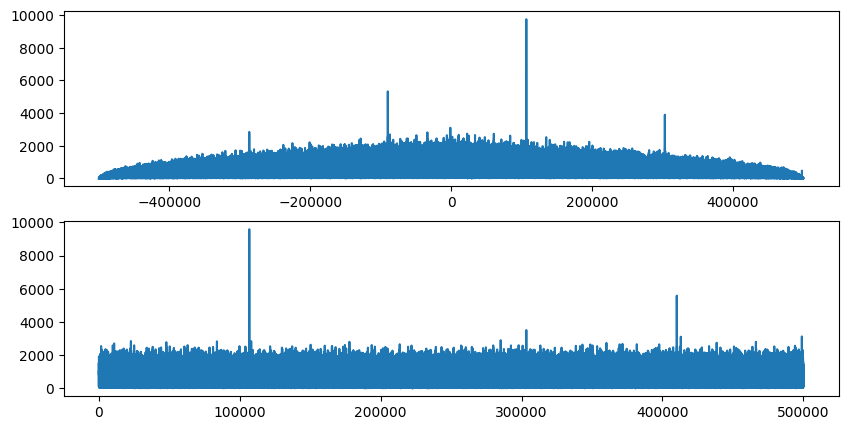

In [6]:
#########
# Algorithm 1:

# simple correlation using xcorr and fft
# note: both should give the same result, however
# the fft version is faster

lags, rxx = xcorr(nn, nn2)
[fig, ax] = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(lags, abs(rxx))
ax[1].plot(abs(np.fft.ifft(np.fft.fft(nn) * np.conj(np.fft.fft(nn2)))))

# In the plot we expect that the maximum correlation will occur
# at the time lag which nn2 is compared to nn

# however, as we also did a frequency shift, this may not be as obvious
# as it normally should be.

Text(0, 0.5, 'Doppler (Hz)')

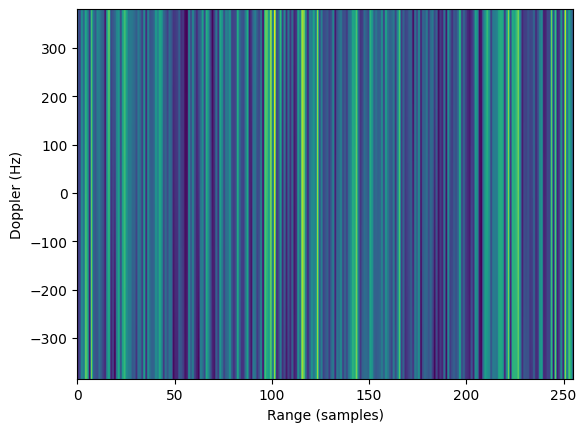

In [7]:
# Algorithm 2:
# a range doppler map (correlation in both time and frequency)
# using the fft correlation presented above.


fmap = np.arange(-(bs*0.75), bs*0.75, 4)  # select some frequency bins

rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
nn2F = np.conj(np.fft.fft(nn2))

# for each frequency offset, calculate the time correlation
for fi in range(len(fmap)):
    f = fmap[fi]
    nnf = nn * np.exp(1j*2*np.pi*-f*t)

    rdmapX[fi,:] = np.fft.ifft(np.fft.fft(nnf) * nn2F)

# figure of RDMAP made using traditional FFT etc
stRDmap = np.zeros((nbatches, overlap))
sdata = np.size(stRDmap)
gridx = np.arange(0, overlap)
gridy = fmap

rdmapXTRUNC = rdmapX[:, 1:overlap]  # only need the first 'overlap' samples
plt.imshow(np.abs(rdmapXTRUNC), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')
# plt.savefig('fullrdmap.png', dpi=360)


# we expect a high intensity dot at the frequency and time shifted
# created in genscenario.m

# note: we need to truncate the time index to only the first 128 samples
# even though the correlation is calculated over all 10000 samples, most
# of them are discarded.
